# Image classification problem by classifying foreground and background regions in an image, using a Gaussian classifier

In [8]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cvxpy as cp
import csv
import imageio
import matplotlib.image as mpimg

## Training on cat and grass data from manually filtered data. 

In [9]:
train_cat = np.matrix(np.loadtxt("train_cat.txt", delimiter = ",")) # cat data as matrix
train_grass = np.matrix(np.loadtxt("train_grass.txt", delimiter = ",")) # grass data as matrix

In [19]:
def train_set(train): # train function to get mean, variance from training samples
    K = np.size(train,1) # number of samples/patch for training 
    u = np.mean(train,1)  # mean vector 
    cov = np.cov(train)   # covariance
    return K,u,cov     

In [20]:
# for this the data contains vector of size(64,1) extracted from 8*8 patch. 
# compute mean vector of grass patch vector, covariance of grass patch vector from sample
t_g = train_set(train_grass)
K_grass = t_g[0] # number of training samples(patches) of grass 
u_grass = t_g[1] # mean vector of grass patch vector
cov_grass = t_g[2]  # covariance of grass patch vector

In [21]:
t_c = train_set(train_cat)
K_cat = t_c[0] # number of training samples(patches) of cat
u_cat = t_c[1] # mean vector of cat patch vector
cov_cat = t_c[2]  # covariance of cat patch vector

In [22]:
# compute prior
P_cat = K_cat/(K_grass + K_cat) # prior P_class(cat)
P_grass = 1-P_cat               # prior P_class(grass)   

In [23]:
# reading image to be classified
Y = plt.imread("cat_grass.jpg") / 255

The task is to extract the cat from the grass, and compare your result with the ground truth to find efficiency.

Classification based on Maximum posterior estimation

In [53]:
# this classifier will go through the image patch by patch and compute if it belongs to cat or grass for each patch
# the consecutive patches will overlap.
def classifier_no_overlap(Y, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass,):
    M = np.size(Y,0)
    N = np.size(Y,1)
    Output_no_ovelap = np.zeros((M,N))
    cat_num = 0 
    
    cov_inv_cat = np.linalg.inv(cov_cat)
    cov_inv_grass = np.linalg.inv(cov_grass)
    log_Pcat = np.log(P_cat)
    log_Pgrass = np.log(P_grass)
    det_cov_grass = np.log(np.linalg.det(cov_grass))
    det_cov_cat = np.log(np.linalg.det(cov_cat))

    
    for i in range(M//8):
        for j in range(N//8):
            z_patch = Y[i*8:(i+1)*8, j*8:(j+1)*8] # extracting a patch
            z1 = z_patch.flatten('F') # flatten patch from 8,8 to a column (64,) 
            z = np.reshape(z1,(64,1))   # now to (64,1) 

            # compute f(z | cat)
            t_cat = z - u_cat
            
            G_cat = np.dot(t_cat.T,cov_inv_cat)
            f_zcat = -0.5*((np.asscalar(np.dot(G_cat,t_cat)))+(det_cov_cat)) # compute f(z | cat)

            t_grass = z - u_grass
            
            G_grass = np.dot(t_grass.T,cov_inv_grass)

            # compute f(z|grass)
            f_zgrass = -0.5*((np.asscalar(np.dot(G_grass,t_grass)))+(det_cov_grass)) # compute f(z | grass)
            fcz = f_zcat+ log_Pcat # posterior probability f(cat | z) 
            fgz = f_zgrass+log_Pgrass # posterior probability f(grass | z) 
            
            if fcz > fgz: 
                Output_no_ovelap[i*8:(i+1)*8, j*8:(j+1)*8] = 1 # assigning it 1 to plot as cat
                cat_num += 1
    return Output_no_ovelap, cat_num


In [54]:
Output_no_overlap, cat = classifier_no_overlap(Y, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass)

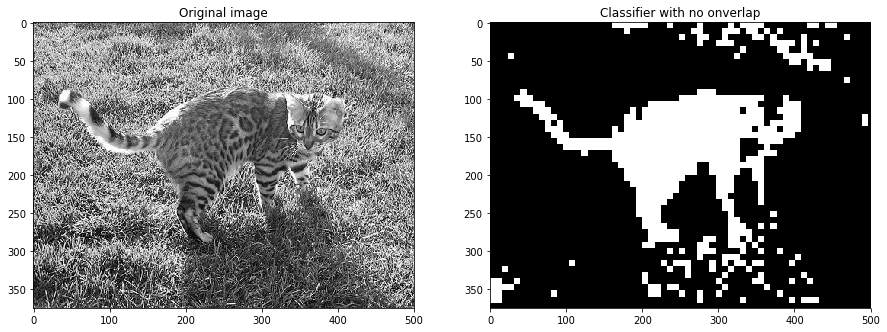

In [55]:
fig = plt.figure(figsize=(15, 32))
plt.subplot(1, 2, 2)
plt.title('Classifier with no onverlap')
plt.imshow(Output_no_overlap*255, cmap = "gray")
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(Y, cmap = 'gray') 

As seen above the classifier fine to classify cat from grass background. Although its not perfect as some grass pixels are also classified as cat.

In [36]:
# this classifier will go through the image patch by patch and compute if it belongs to cat or grass for each patch
# the consecutive patches will overlap.
def classifier_overlap(Y, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass):
    
    M = np.size(Y,0)
    N = np.size(Y,1)
    Output = np.zeros((M,N)) # initial matrix of zero, 1 will be assigned for cat, 0 is for grass
    
    cat_c = 0
    
    cov_inv_cat = np.linalg.inv(cov_cat)
    cov_inv_grass = np.linalg.inv(cov_grass)
    log_Pcat = np.log(P_cat)
    log_Pgrass = np.log(P_grass)
    det_cov_grass = np.log(np.linalg.det(cov_grass))
    det_cov_cat = np.log(np.linalg.det(cov_cat))
    
    for i in range(M-8):
        for j in range(N-8):
            z_patch = Y[i:i+8, j:j+8] # extracting a patch
            z1 = z_patch.flatten('F') # flatten patch from 8,8 to a column (64,) 
            z = np.reshape(z1,(64,1))  # now to (64,1) 
            
            t_cat = z - u_cat         
            G_cat = np.dot(t_cat.T,cov_inv_cat)
            f_zcat = -0.5*((np.asscalar(np.dot(G_cat,t_cat)))+(det_cov_cat)) # compute f(z | cat)

            t_grass = z - u_grass            
            G_grass = np.dot(t_grass.T,cov_inv_grass)
            # compute f(z|grass)
            f_zgrass = -0.5*((np.asscalar(np.dot(G_grass,t_grass)))+(det_cov_grass))# compute f(z | grass) 
        
            
            fcz = f_zcat+ log_Pcat # posterior probability f(cat | z) 
            fgz = f_zgrass+ log_Pgrass # posterior probability f(grasz | z)            
            if fcz > fgz: # # if f(cat | z) > f(grass | z) then patch is cat
                Output[i,j] = 1 # assigning it 1 to plot as cat
                cat_c = cat_c + 1
    return Output, cat_c


In [34]:
Output, cat_num = classifier_overlap(Y, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass)

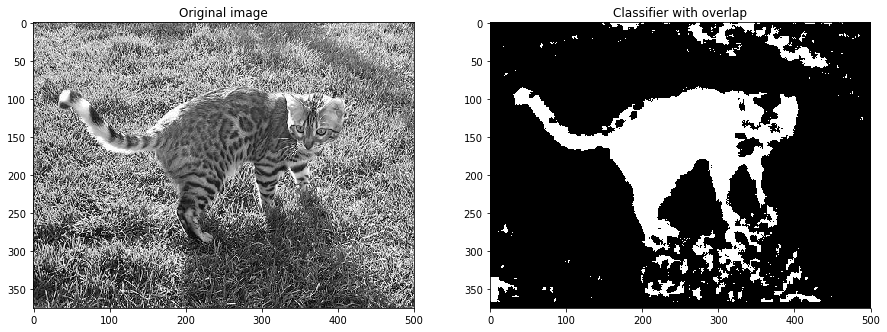

In [32]:
fig = plt.figure(figsize = (15,32))
plt.subplot(1,2,1)
plt.imshow(Y, cmap = "gray")
plt.title('Original image')

plt.subplot(1,2,2)
plt.imshow(Output*255, cmap = "gray")
plt.title('Classifier with overlap')
plt.show()

This classification is better than the previous as it assigining pixel by pixel instead of assigning patch by patch.  . 

# Finding the error for above 2 classifiers by comparing with the ground truth

In [56]:
Y_star = plt.imread("truth.png")
M_c = np.size(Output, 0)
N_c = np.size(Output, 1)
AE_o = []
AE_no_overlap = []
for i in range(M_c):
    for j in range(N_c):
        y_n_star = Y_star[i,j]
        y_n = Output[i,j]
        y_n_no_overlap = Output_no_overlap[i,j]
        ae_o = abs(y_n_star-y_n)
        ae_no_overlap = abs(y_n_star-y_n_no_overlap) 
        AE_o.append(ae_o)
        AE_no_overlap.append(ae_no_overlap)

In [57]:
MAE_no_overlap = np.mean(AE_no_overlap)
MAE_o = np.mean(AE_o)
print("Mean Absolute Error for classifier with no overlap =", MAE_no_overlap)
print("Mean Absolute Error for classifier with overlap = =", MAE_o)

Mean Absolute Error for classifier with no overlap = 0.09203844185137748
Mean Absolute Error for classifier with overlap = = 0.09022351896802584


In [60]:
from PIL import Image
img = Image.open('billi.jpeg').convert('L')
img.save('billi_gray.jpeg')

Y1 = plt.imread("billi_gray.jpeg") / 255
M1= np.size(Y,0)
N1 = np.size(Y,1)

In [64]:
Output1_no_overlap = classifier_no_overlap(Y1, P_cat, P_grass, u_cat, u_grass, cov_cat, cov_grass)

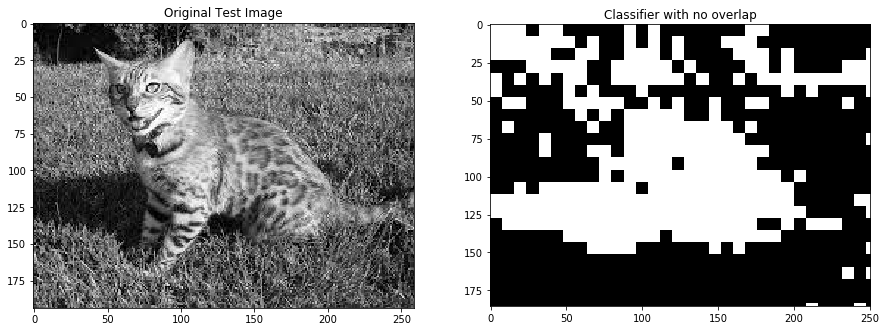

In [69]:
fig = plt.figure(figsize = (15,32))
plt.subplot(1,2,1)
plt.title('Original Test Image')
plt.imshow(Y1, cmap = "gray")

plt.subplot(1,2,2)
plt.title("Classifier with no overlap")
plt.imshow(Output1_no_overlap*255, cmap="gray")

As seen above the classifier has poor performance. This is because: <br>
Our training set is very less and works on 1 particular image. <br>
In order to get better performance we need to train it on many different images of cat and grass.